# Simplest ETU3 model - CW

3 _ \
2 _ \
1 _ _ b \
0 _ _ a\
...A S...

## Study of delivered UC power for various excitation pulse profiles 

$P_{avg} = P_{peak} \cdot \frac{\Delta t}{T}$

In [3]:
%matplotlib notebook
import matplotlib.pyplot as pl
from scipy import constants
from sympy import init_session, solve, lambdify, Symbol, symbols, Eq
from sympy.physics.mechanics import dynamicsymbols
import sys
sys.path.append('../scripts/')
sys.path.append('../utils/')
from virtualab import Sample, Laser, Experiment
import utils

## Create new experiment

In [5]:
experiment = Experiment()

### Prepare laser

In [6]:
# Laser ramp: 0 to 1000 W/cm^2
laser = Laser(wavelength=976e-9, mode='linear')

laser.range = (0, 1000, 100)
laser.samplesPerStep = 100
laser.samplingRate = 1e5 # number of points per second

### Prepare sample

##### Unit cell: 

$NaY_{(1-x-y)}F_4:Yb_{x}Tm_{y}$

$Volume = \sqrt{3} / 2 a_h^2 c_h $ 

In [ ]:
sample = Sample(name='ETU3-simple-model')

In [34]:
# Unit cell
x = 0.20
y = 0.01

# https://www.nature.com/articles/s41598-018-19415-w#citeas
ah = 5.91e-8 # cm
ch = 3.53e-8 # cm
vu = ah**2 * ch * 3**(0.5) / 2

# Density of states
NS = x / vu # Sensitizer
NA = y / vu # Activator

print(f'{NS=}, {NA=}')

NS=1.8730514061845395e+21, NA=9.365257030922697e+19


#### Energy states

$\vert{a} \rangle$ : Yb- $^2F_{7/2}$ \
$\vert{b} \rangle$ : Yb- $^2F_{5/2}$

$\vert{0} \rangle$ : Tm- $^3H_{6}$ \
$\vert{1} \rangle$ : Tm- $^3H_{5}$ - $^3F_{4}$ \
$\vert{2} \rangle$ : Tm- $^3F_{2,3}$ - $^3H_{4}$ \
$\vert{3} \rangle$ : Tm- $^1G_{4}$ \
$\vert{4} \rangle$ : Tm- $^1D_{2}$ 

In [35]:
# ET constants and decay rates
# sigma = 1.69e-20 # cm2 Liu2013
# taub = 1.32e-3   # s Liu2013
# tau1 = 7.43e-3   # s Liu2013
# tau2 = 1.49e-3   # s Liu2013

sigma = 1e-21    # cm2 Delgado2015
taub = 2.3e-3    # s Delgado2015
tau1 = 12e-3     # s Delgado2015
tau2 = 2e-3   # s Delgado2015
tau3 = 675e-6    # s Delgado2015
tau4 = 500e-6    # s Delgado2015


w0 = 1.6e-18     # cm3/s Liu2013
w1 = 6.2e-16     # cm3/s Liu2013
w2 = 1.6e-18     # cm3/s Liu2013
w3 = 1.6e-18     # cm3/s Liu2013

W1 = R1 * Rb / (alpha * Ns * 40)
W2 = R2 * Rb / (alpha * Ns * 50)

In [33]:
electronicPop_S, electronicPop_A = utils.REConc(x=0.12, y=0.001)

NYb=1.5322875172623467e+21, NTm=1.276906264385289e+19


#### Rate equations and constants

In [8]:
constants.h * constants.c / laser.wavelength

2.0352928864230824e-19

In [9]:
w2 = 1.7e-1*6.2e-16*58/4/10
w2

1.5283e-16

In [10]:
# Population densities 
Na, Nb, N0, N1, N2, N3 = dynamicsymbols("N_a N_b N_0 N_1 N_2 N_3")

# Total population
Nsens, Nact = symbols('N_sens N_act')
sample.props.update({Nsens: electronicPop_S})
sample.props.update({Nact: electronicPop_A})

# Energy transfer (W2 from experimental data)
W0, W1, W2 = symbols('W_0 W_1 W_2')
sample.props.update({W0: 1.6e-18}) # energy transfer upconversion rate in s^-1
sample.props.update({W1: 6.2e-16}) # energy transfer upconversion rate in s^-1
sample.props.update({W2: 1.52e-16}) # energy transfer upconversion rate in s^-1

# Decay rates (Delgado 2015)
Rba, R10, R20, R30 = symbols('R_{ba} R_{10} R_{20} R_30')
sample.props.update({Rba: 1 / 1.32e-3}) # s^-1
sample.props.update({R10: 1 / 58e-6}) # s^-1
sample.props.update({R20: 1 / 10e-6}) # s^-1
sample.props.update({R30: 1 / 675e-6}) # s^-1

# Cross section
sigmaab = symbols('sigma_ab')
sample.props.update({sigmaab: 1.69e-20}) # cm^-2

# constants
h, nu = symbols('h nu')
sample.props.update({h: constants.h}) # Planks constant
sample.props.update({nu: constants.c / laser.wavelength}) # frequency of excitation

# time
t = symbols('t')

# power density
p = symbols('rho')

# Rate equations
NaRate = Eq(Na.diff(t), Rba * Nb - sigmaab * p / (h * nu) * (Nsens - Nb))
NbRate = Eq(Nb.diff(t), - NaRate.rhs)

N0Rate = Eq(N0.diff(t), R30 * N3 + R20 * N2 + R10 * N1 - W0 * Nb * N0)
N1Rate = Eq(N1.diff(t), W0 * Nb * N0 - W1 * Nb * N1 - R10 * N1)
N2Rate = Eq(N2.diff(t), W1 * Nb * N1 - W2 * Nb * N2 - R20 * N2)
N3Rate = Eq(N3.diff(t), W2 * Nb * N2 - R30 * N3)

# Bind model to sample
sample.model([(Nb, NbRate, 0), (N0, N0Rate, sample.props[Nact]), (N1, N1Rate, 0), (N2, N2Rate, 0), (N3, N3Rate, 0)])
sample.boundaryConds = {Nb: [0, sample.props[Nsens]], N0: [0, sample.props[Nact]], N1: [0, sample.props[Nact]], N2: [0, sample.props[Nact]], N3: [0, sample.props[Nact]]}


In [11]:
# Rate equations used on the simulations
sample.showequations()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Run experiment

In [12]:
experiment.new(laser, sample)

Laser on 🚨: 100%|█████████████████| 9999/9999 [10:40<00:00, 15.61it/s]


#### Add ground states 

In [13]:
# N_0
# experiment.sample.data['N_0'] = experiment.sample.props[Nact] - (
#     experiment.sample.data['N_1'] + experiment.sample.data['N_2'] + experiment.sample.data['N_2']
# )
# N_a
experiment.sample.data['N_a'] = experiment.sample.props[Nsens] - experiment.sample.data['N_b']

In [14]:
experiment.sample.data.loc[:5]

,t,power,N_b,N_0,N_1,N_2,N_3,N_a
0,0.00000,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21
1,0.00001,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21
2,0.00002,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21
3,0.00003,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21
4,0.00004,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21
5,0.00005,0.0,0.0,1.276906e+19,0.0,0.0,0.0,1.532288e+21


<IPython.core.display.Javascript object>


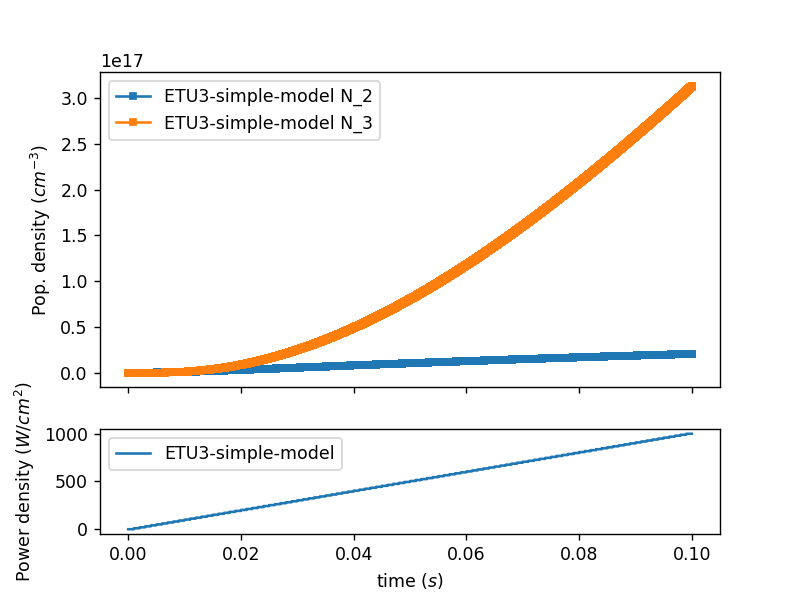

array([<AxesSubplot:ylabel='Pop. density ($cm^{-3}$)'>,
       <AxesSubplot:xlabel='time $(s)$', ylabel='Power density $(W/cm^2)$'>],
      dtype=object)

In [17]:
experiment.plot(x='t', yList=[ 'N_2', 'N_3'])

<IPython.core.display.Javascript object>


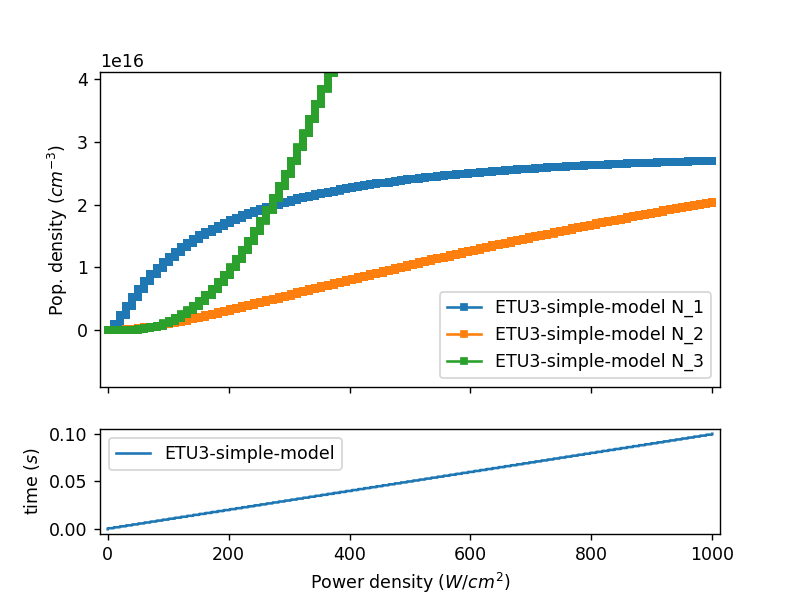

array([<AxesSubplot:ylabel='Pop. density ($cm^{-3}$)'>,
       <AxesSubplot:xlabel='Power density $(W/cm^2)$', ylabel='time $(s)$'>],
      dtype=object)

In [23]:
experiment.plot(x='power', yList=['N_1', 'N_2', 'N_3'])

In [15]:
experiment.save('simplest_etu3_laser_ramp')

Data saved: ..\output\pulse_study_etu3_cw.csv!


In [14]:
experiment.load('pulse_study_etu3_cw')

In [19]:
vars(experiment)['laser'].mode

'pulse'

### Balancing point constants
$\rho_1 = \frac{R_{10}R_{ba}}{W_1 N_a}$

$\rho_2 = \frac{R_{20}R_{ba}}{W_2 N_a}$

$\eta_{20} = \frac{W_0 N_0 R_{20}^{rad}}{R_{ba}R_{20}}$

$\eta_{30} = \frac{W_0 N_0 R_{30}^{rad}}{R_{ba}R_{30}}$

In [13]:
rho1 = sample.props[R10] * sample.props[Rba] / (sample.props[W1] * sample.props[Nsens])
rho2 = sample.props[R20] * sample.props[Rba] / (sample.props[W2] * sample.props[Nsens])

etab = sample.props[W0] / 1.5e-3 * sample.props[Nact] / (sample.props[Rba] * sample.props[R20])

In [12]:
rho1

13.859986197671343

In [13]:
rho2

327.8980945185931

In [18]:
etab

1.7664